# Katz centrality and Google's PageRank

## Google's PageRank

In [30]:
#import libraries
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

For simplicity we will not take directed graphs but rather undirected and then assume that every edge points in both directions.

In [31]:
#computing adjacency matrix, belonging to graph G and H
G = nx.barabasi_albert_graph(5,1) 
H = nx.complete_graph(100)
M = nx.adjacency_matrix(G)
N = nx.adjacency_matrix(H)
#print(M.todense())

### Algorithm 
#### General model
1. generate network
2. find square "adjacency matrix" Q that belongs to selected network: <br>
     (i,j) = 1/(#outlinks of j) ; if there exists a link from j to i <br>
     (i,j) = 0 ; otherwise <br>
The sum of every column should be 1. <br>
3. use power method for finding eigenvector r <br>
     for k=1,2... until convergence: <br>
        r^(k) = Q*r^(k-1)

In [32]:
def Qmatrix(matrix):
    '''for given adjecency matrix returns column stohastic matrix Q'''
    sums = np.sum(matrix, axis=0)        #array of sums of columns in matrix
    return matrix/sums                   #divide every column with its sum

def pagerank1(matrix, max_num_of_steps, tolerance):
    '''returns pagerank vector of matrix, 
    warning: do not use this function when #(nodes) * max_num_of_steps >> 100000'''
    start = timer()
    Q = Qmatrix(matrix)           #column stohastic matrix from given matrix
    r = Q[:,0]                    #first guess for vector r is first column of Q 
    for k in range (1,max_num_of_steps):
        r = Q.dot(r)              #inner product of matrix Q and vector r
        #r = q/np.linalg.norm(q, ord=1)  #not necessary
    end = timer()
    print('time consumption: {} seconds'.format(end-start))  #timing of the process
    return r

First, we check if the function pagerank1 works correctly. We use it on complete graph, where we know what is the correct pagerank vector. 
We will compare how size of graph (number of nodes and edges), prescribed maximum number of steps, inclusion of normalizing the vector and different first guesses for vector r affect time consumption of iteration and precision of pagerank vector.  

In [33]:
pagerank1(N, 1000000, 0)
pagerank1(N, 100, 0)

time consumption: 3.773298282000013 seconds
time consumption: 0.0022522320000177842 seconds


matrix([[0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        [0.01],
        

With enough number of steps we get the right result, so pagerank1 works correctly. 
Now we use it on barabasi albert graph.

In [34]:
#pagerank1(M, 1000, 0)
pagerank1(M, 1000, 0)
#Qmatrix(M) (different result if with norm of vector r)

time consumption: 0.010930064999996603 seconds


matrix([[0.5 ],
        [0.  ],
        [0.  ],
        [0.25],
        [0.25]])

Ranking says that some pages are not important at all. For better intuition lets take a look at this graph.

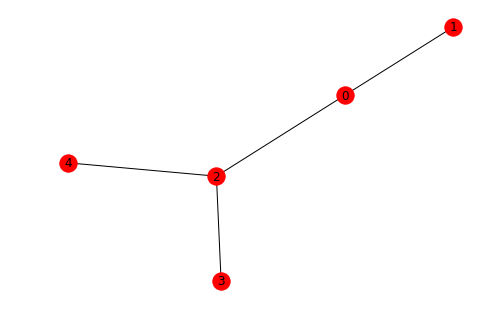

In [35]:
nx.draw(G, with_labels=True)
plt.show()

#### Adjusted model
1. generate network
2. find matrix Q and then adjust it: every zero column should have constant values in all places: <br>
    d[j] = 1 ; if #(outlinks of j) = 0 <br>
    d[j] = 0 ; otherwise <br>
    e = [1 ... 1]^T <br>
    => P = Q + 1/n*e*d^t <br>
    => A =  α*P + (1- α)/n*e*e^T, where 0 <= α <=1 <br>
3. use power method for finding r <br>
    for k=1,2... until convergence: <br>
        r^(k) = A*r^(k-1)

In [36]:
def Qmatrix(matrix):
    '''for given adjecency matrix of a network returns column stohastic matrix Q,
    some columns may still be zero'''
    sums = np.sum(matrix, axis=0)       #array of sums of columns in matrix
    return np.nan_to_num(matrix/sums)   #divide every column with it's sum, if sum is 0,  
                                        #returns zero column instead of nan

def dvector(matrix):
    '''for given adjecency matrix returns transposed vector d, where d[j] = 1 ; if #(outlinks of j) = 0 
    and d[j] = 0 ; otherwise'''
    Q = Qmatrix(matrix)             #compute matrix Q
    sums = np.sum(matrix, axis=0)   #array of sums of columns in matrix 
    d_bool = (sums == 0)            #booleninan array, True if the sum of a column is equal to 0, false otherwise
    d = d_bool*1                    #convert False to 0 and True to 1
    return d

def evector(n):
    '''returns vector v of ones in size of n''' # n = num of columns in matrix
    return np.ones((n,1))    

def Pmatrix(matrix):
    '''returns column stohastic matrix P without zero columns'''
    n = matrix.shape[1]
    Q = Qmatrix(matrix)
    e = evector(n)
    d = dvector(matrix)
    return Q + 1/n*e.dot(d)

def Amatrix(matrix, alpha):
    '''returns ireducible column stohastic matrix A of given matrix, 
    where 0 <= alpha <= 1'''
    n = matrix.shape[1]
    e = evector(n)
    P = Pmatrix(matrix)
    return alpha*P + (1-alpha)*1/n*e.dot(e.transpose())

def pagerank2(matrix, max_num_of_steps, tolerance, alpha):
    '''returns pagerank vector of matrix, 
    warning: do not use this function when #(nodes) * max_num_of_steps >> 1000000'''
    start = timer()
    A = Amatrix(matrix, alpha)           #column stohastic matrix from given matrix
    r = A[:,0]                           #first guess for vector r is first column of Q 
    for k in range (1,max_num_of_steps):
        r = A.dot(r)                     #inner product of matrix Q and vector r
        #r = q/np.linalg.norm(q, ord=1)  #not necessary
    end = timer()
    print('time consumption: {} seconds'.format(end-start))  #timing of the process
    return r

Let's see how every one of these functions works and what output they produce. <br>
Firstly, let's take a look at adjacency matrix of directed graph $T$:

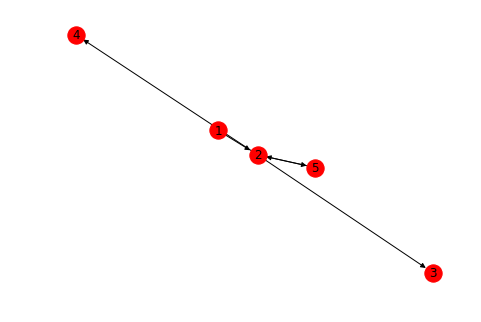

[[0 1 0 0 0]
 [0 0 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]


In [37]:
T = nx.DiGraph()   # or DiGraph, etc
T.add_edges_from( ((1,2), (2,3), (2,4), (2,5), (5,2)) )
nx.draw(T, with_labels=True)
plt.show()
R = nx.adjacency_matrix(T)
print(R.todense())

First column of $R$ is a zero column and general pagerank (pagerank1) does not work well in these cases. Now we compute column stohastic matrix Q with *Qmatrix* function. Zero column will not change in this process.

In [38]:
Qmatrix(R)

C:\Users\COMCOM\Anaconda3\lib\site-packages\scipy\sparse\base.py:594: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


matrix([[0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 1. , 1. , 1. ],
        [0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. , 0. ]])

That zero column could be a problem. It means that random surfer in this network could get stuck in that web page. We replace zeros with equal constant values in all places. For that we use the *Pmatrix* function. 

In [39]:
Pmatrix(R)

C:\Users\COMCOM\Anaconda3\lib\site-packages\scipy\sparse\base.py:594: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


matrix([[0.2, 0.5, 0. , 0. , 0. ],
        [0.2, 0. , 1. , 1. , 1. ],
        [0.2, 0. , 0. , 0. , 0. ],
        [0.2, 0. , 0. , 0. , 0. ],
        [0.2, 0.5, 0. , 0. , 0. ]])

Zero column was replaced by 0.2 in all places. Now we have a real column stohastic matrix. <br>
Next, we want to have irreducible matrix, which due to the size of the web, we usually do not have. For that purpuse we add links from and to all pages with *Amatrix* function.   


In [40]:
Amatrix(R, 0.98)

C:\Users\COMCOM\Anaconda3\lib\site-packages\scipy\sparse\base.py:594: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


matrix([[0.2  , 0.494, 0.004, 0.004, 0.004],
        [0.2  , 0.004, 0.984, 0.984, 0.984],
        [0.2  , 0.004, 0.004, 0.004, 0.004],
        [0.2  , 0.004, 0.004, 0.004, 0.004],
        [0.2  , 0.494, 0.004, 0.004, 0.004]])

In [41]:
pagerank2(R,10000000,0, 0.99)

C:\Users\COMCOM\Anaconda3\lib\site-packages\scipy\sparse\base.py:594: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


time consumption: 13.902181803000019 seconds


matrix([[0.24900152],
        [0.39939236],
        [0.0513023 ],
        [0.0513023 ],
        [0.24900152]])

time consumption: 0.0019154489991706214 seconds


C:\Users\COMCOM\Anaconda3\lib\site-packages\scipy\sparse\base.py:594: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


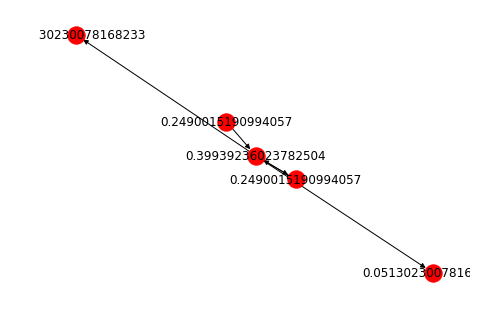

0.2490015190994057

In [79]:
#pagerank on graph
from itertools import chain
r = pagerank2(R,100,0, 0.99) 
keys = list(range(1, r.shape[0]+2))
values = list(chain.from_iterable(r.tolist()))
t = {k: v for k, v in zip(keys, values)}
#t
nx.set_node_attributes(T, t, 'pagerank')
nx.draw(T, with_labels=True, labels = t, with_attributes=True)
plt.show()
T.node[1]['pagerank']

In [42]:
pagerank1(R, 1000000, 0)

C:\Users\COMCOM\Anaconda3\lib\site-packages\scipy\sparse\base.py:594: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


time consumption: 1.0955170399999759 seconds


matrix([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])